In [1]:
from classes import *
from utils import *
import math

from typing import List, Set, Tuple, Any, Dict, DefaultDict, Optional
from collections import defaultdict
import linearize_io_helper as hp

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# make the font of the plots bigger
plt.rcParams.update({'font.size': 14})

<IPython.core.display.Javascript object>

In [102]:
def linearize_io(spec: List[Call], verbose=False):
    sort_by_var: DefaultDict[int, List[Call]] = defaultdict(list)
    false_cases: List[CallCAS] = []
    true_cases: List[CallCAS] = []

    hp.populate_call_bins(spec, sort_by_var, true_cases, false_cases)

    writes = hp.basic_io_checks(sort_by_var)
    if writes is None:
        if verbose:
            print("basic_io_checks failed")
        return False

    if hp.isAny_cas_intersect_write(false_cases, writes):
        raise Exception("Assumption Violation: CAS intersects Write")

    if not hp.basic_true_cas_checks(true_cases):
        if verbose:
            print("basic_true_cas_checks failed")
        return False

    hp.topological_true_cas_sort(true_cases)

    true_cas_var_groups = hp.make_true_cas_var_groups(true_cases)

    if not hp.intra_group_check(sort_by_var, true_cas_var_groups):
        if verbose:
            print("intra_group_check failed")
        return False

    if not hp.inter_group_check(sort_by_var, true_cas_var_groups):
        if verbose:
            print("inter_group_check failed")
        return False

    intervals: Dict[int, I] = hp.make_intervals(sort_by_var)

    if not hp.io_check(intervals):
        if verbose:
            print("io_check failed")
        return False

    blocks = hp.make_blocks(sort_by_var, intervals, true_cas_var_groups)

    false_cas_var_resolver = hp.get_false_cas_resolvers(sort_by_var, false_cases, blocks, writes, intervals)

    if not hp.false_cas_group_check(false_cas_var_resolver, writes):
        if verbose:
            print("false_cas_group_check failed")
        return False

    if verbose:
        print(blocks)
        print({f"{k} ({round(k.start, 2)} - {round(k.end,2)})": v for k, v in false_cas_var_resolver.items()})

    for false_cas in false_cases:
        if len(false_cas_var_resolver[false_cas]) == 0:
            if verbose:
                print("false_cas_var_resolver[false_cas] == 0")
            return False

    # it is linearizable
    for false_cas in false_cases:
        v = false_cas_var_resolver[false_cas].pop()
        sort_by_var[v].append(false_cas)

    hp.set_order(sort_by_var, true_cas_var_groups)

    return True


<IPython.core.display.Javascript object>

In [4]:
# generate_tests(filename="megatests.pkl",
#                success_percentage=0.1,
#                total=20_000,
#                no_threads=7,
#                no_operations=20,
#                no_variables=5,
#                min_ops=7,
#                min_cas=1,
#                min_read=1,
#                min_offset=1,
#                max_offset=5,
#                min_duration=1,
#                max_duration=5)


<IPython.core.display.Javascript object>

In [8]:
test = load_test("testcas_filtered.pkl")

747188it [00:30, 24534.32it/s]


<IPython.core.display.Javascript object>

In [9]:
len(test)

747188

<IPython.core.display.Javascript object>

In [10]:
# test = [t for t in test if isIntervals_strictly_ordered(t[0])]
# test = [t for t in test if isRead_before_cas(t[0])]
# test = [t for t in test if not isAny_fcas_intersect_write_comb(t[0])]

<IPython.core.display.Javascript object>

In [11]:
len(test)

747188

<IPython.core.display.Javascript object>

In [12]:
# save_test(test, "testcas_filtered.pkl")


<IPython.core.display.Javascript object>

In [13]:
# assert len(new_test) == len(test)

<IPython.core.display.Javascript object>

In [16]:
def run_test(testsample: List[Tuple[List[Call], bool]]):
    wrong_test_no = []
    for i in tqdm.tqdm(range(len(testsample))):
        testcase, res = copy.deepcopy(testsample[i])
        try:
            sol = linearize_io(testcase)
            s2 = (sol is True)
            if res ^ s2:
                wrong_test_no.append(i)

        except AssertionError as e:
            raise e

    print(f"Tests failed: {len(wrong_test_no)}")
    if len(wrong_test_no) == 0:
        print("All tests passed")
    else:
        print(f"First failed: {str(wrong_test_no[:10]).strip('[]')} ...")
    
    return wrong_test_no

<IPython.core.display.Javascript object>

In [103]:
wrong_test_no = run_test(test)

100%|██████████| 747188/747188 [01:39<00:00, 7515.78it/s]

Tests failed: 0
All tests passed


<IPython.core.display.Javascript object>

Testcase 725564 is True
[[4, 0], [3], [1]]
False


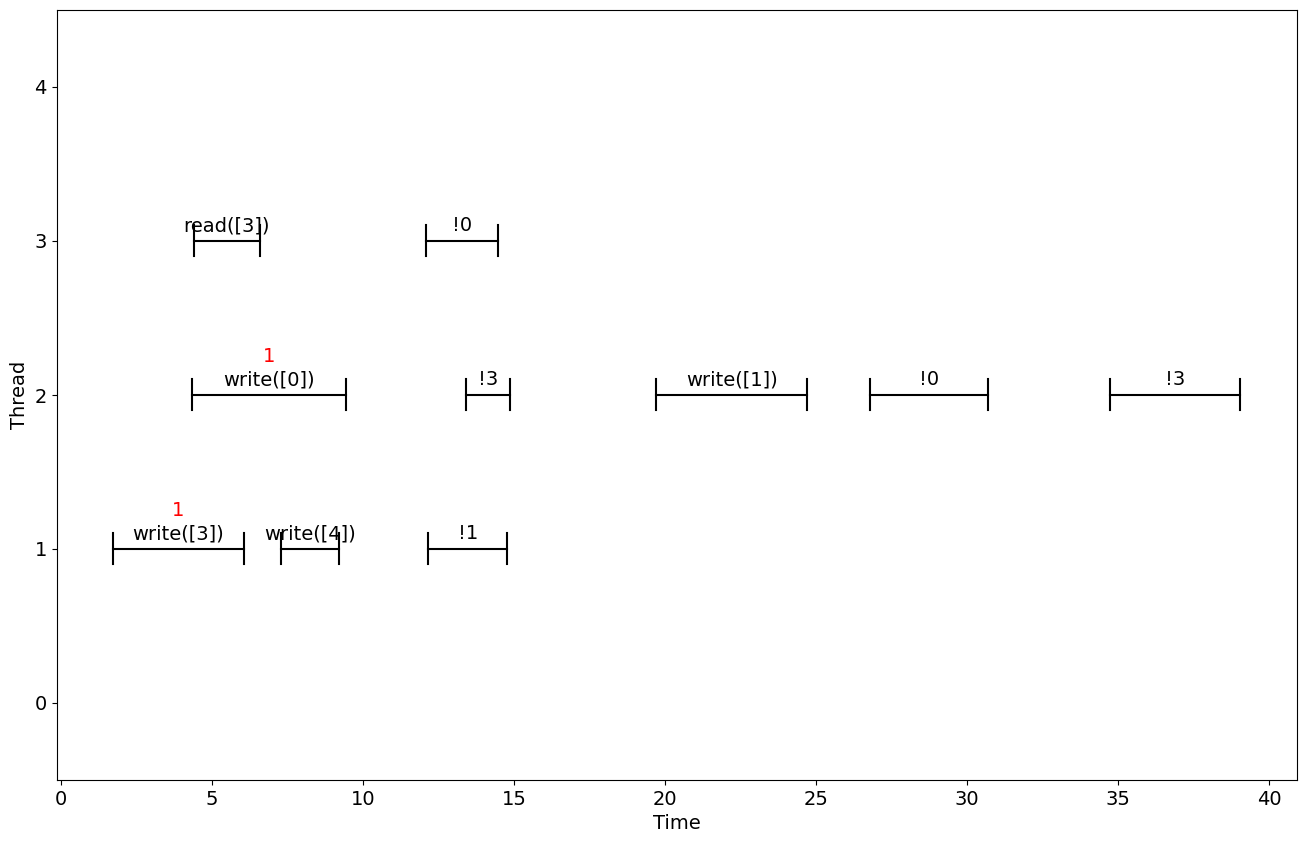

<IPython.core.display.Javascript object>

In [99]:
i = 725564
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
print(linearize_io(testcase, verbose=False))
# sol = linearize_generic(testcase, StateIO())
# visualize_history(testcase)
visualize_history(testcase)

Testcase 165096 is True


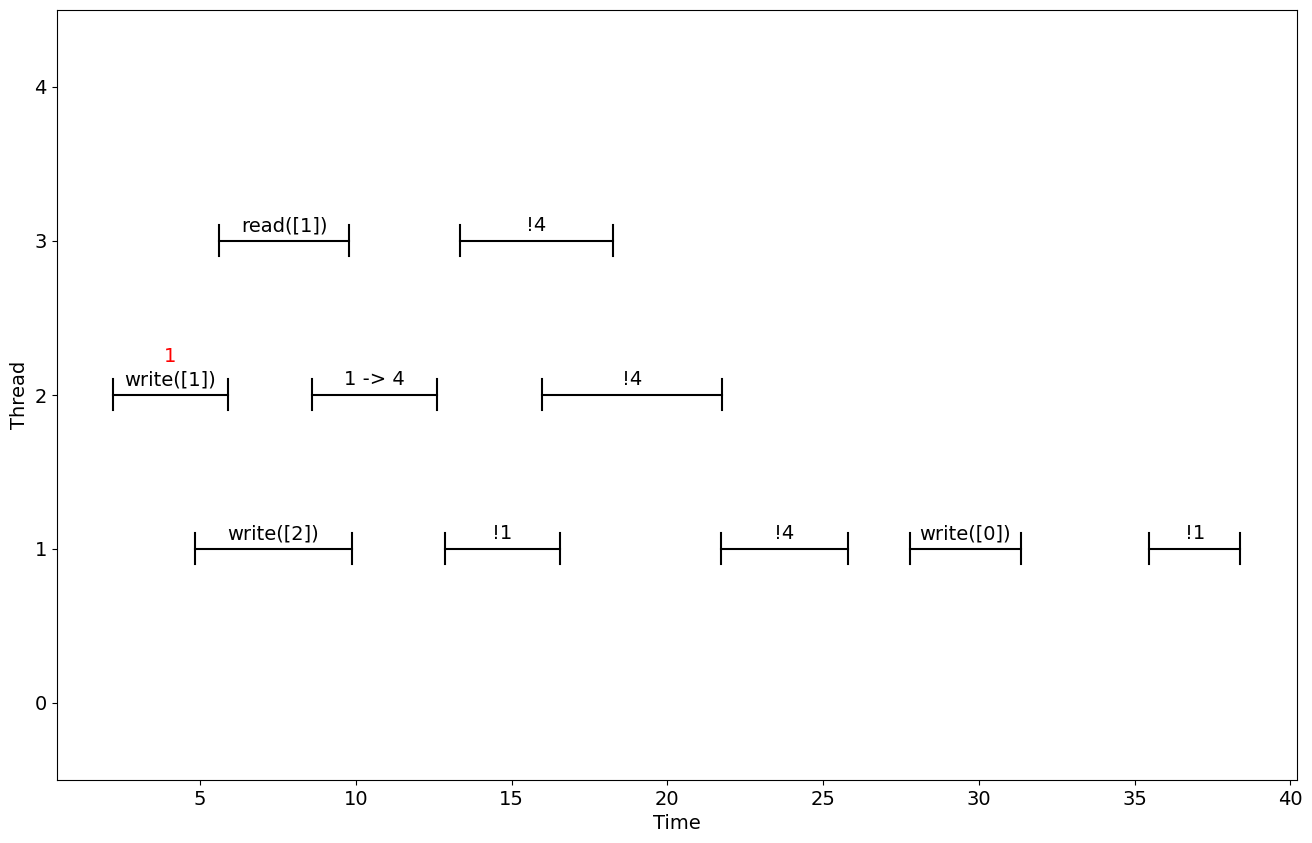

<IPython.core.display.Javascript object>

In [64]:
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
visualize_history(testcase)

In [ ]:
for wrong_test in no[:10]:
    testcase, res = copy.deepcopy(test[wrong_test])
    print(f"Testcase {wrong_test} is {res}")
    print(linearize_io(testcase, verbose=True))
    visualize_history(testcase)